In [2]:
!pip install tiktoken
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.1 MB/s eta 0:00:00


In [3]:
GPT_CONFIG_124M = {
    # Model Configuration
    "vocab_size": 50257,           # Size of vocabulary (tokenized)
    "context_length": 512,        # Maximum sequence length is 1024 (context window)
    "emb_dim": 768,                # Embedding dimension (vector size for each token)
    "n_heads": 12,                 # Number of attention heads in the MultiHeadAttention
    "n_layers": 12,                # Number of Transformer layers
    "drop_rate": 0.1,              # Dropout rate for regularization
    "qkv_bias": False,             # Whether to add bias to the Q, K, V linear projections

    # Training Configuration
    "batch_size":4 ,               # Batch size for training (adjust as needed)
    "learning_rate": 1e-4,         # Learning rate for the optimizer
    "weight_decay": 0.001,          # Weight decay for regularization
    "epochs": 25              # Number of training epochs
}


In [4]:
import torch
from torch.utils.data import Dataset
import pandas as pd

class GPTDataset(Dataset):
    def __init__(self, text_file=None, csv_file=None, tokenizer=None, max_length=256, stride=128):
        self.input_ids = []
        self.target_ids = []
        self.tokenizer = tokenizer

        if csv_file:
            # Load CSV data
            data = pd.read_csv(csv_file)

            # Ensure the required columns are present
            if not {"focus_area", "question", "answer"}.issubset(data.columns):
                raise ValueError("CSV file must contain 'focus_area', 'question', and 'answer' columns")

            # Format focus area, question, and answer pairs
            formatted_data = [
                f"Focus Area: {row['focus_area']}\nQuestion: {row['question']}\nAnswer: {row['answer']}\n<|endoftext|>"
                for _, row in data.iterrows()
            ]

            # Tokenize and create chunks
            for text in formatted_data:
                tokens = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
                self._create_sequences(tokens, max_length, stride)

        elif text_file:
            # Load plain text file (existing functionality)
            with open(text_file, 'r', encoding='utf-8') as f:
                text = f.read()
            tokens = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
            self._create_sequences(tokens, max_length, stride)

    def _create_sequences(self, tokens, max_length, stride):
        for i in range(0, len(tokens) - max_length, stride):
            input_chunk = tokens[i:i + max_length]
            target_chunk = tokens[i + 1:i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


In [5]:
import torch
from torch.utils.data import DataLoader, random_split
import tiktoken
#from gpt_dataset_class import GPTDataset  # Import the GPTDataset class

def load_and_split_data(text_file=None, csv_file=None, config=None):
    if text_file is None and csv_file is None:
        raise ValueError("Either 'text_file' or 'csv_file' must be provided.")
    if text_file is not None and csv_file is not None:
        raise ValueError("Provide only one of 'text_file' or 'csv_file'. Not both.")

    tokenizer = tiktoken.get_encoding("gpt2")  # Using GPT-2 tokenizer

    # Load the dataset using GPTDataset
    dataset = GPTDataset(
        text_file=text_file,
        csv_file=csv_file,
        tokenizer=tokenizer,
        max_length=config["context_length"],  # Max length for tokenized input
        stride=config["context_length"] // 2  # Overlap for sliding window
    )

    total_size = len(dataset)  # Length of the dataset
    train_ratio = 0.9  # 90% for training and 10% for validation
    train_size = int(train_ratio * total_size)
    val_size = total_size - train_size

    # Sanity checks to ensure enough data for training and validation
    total_tokens = len(dataset.input_ids) * config["context_length"]
    if total_tokens * train_ratio < config["context_length"]:
        raise ValueError(
            "Not enough tokens for the training loader. "
            "Try to lower the `context_length` or increase the `training_ratio`."
        )

    if total_tokens * (1 - train_ratio) < config["context_length"]:
        raise ValueError(
            "Not enough tokens for the validation loader. "
            "Try to lower the `context_length` or decrease the `training_ratio`."
        )

    # Split dataset into train and validation sets
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create DataLoader for train and validation datasets
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    return train_loader, val_loader


In [6]:
# GELU class
import torch
import torch.nn as nn

class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))


In [7]:
# FeedForward class
import torch
import torch.nn as nn
#from src.models.gelu import GELU  # Assuming GELU is a custom activation function

class FeedForward(nn.Module):
    def __init__(self, emb_dim, dropout=0.1):
        super().__init__()

        # Define the FeedForward network using nn.Sequential
        self.net = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),  # First Linear layer
            GELU(),                           # Activation function
            nn.Linear(4 * emb_dim, emb_dim),  # Second Linear layer
            nn.Dropout(dropout)               # Dropout for regularization
        )

    def forward(self, x):
        return self.net(x)  # Forward pass through the sequential layers


In [8]:
# LayerNorm class
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-5):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

#builin class
# import torch
# import torch.nn as nn

# class LayerNorm(nn.Module):
#     def __init__(self, emb_dim, eps=1e-5):
#         super().__init__()
#         self.norm = nn.LayerNorm(emb_dim, eps=eps)  # Use built-in LayerNorm

#     def forward(self, x):
#         return self.norm(x)  # Forward pass through built-in LayerNorm



In [9]:
# MultiHeadAttention class
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "Embedding dimension(d_out) must be divisible by number of heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        # Create the causal mask for self-attention
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        # Assert that num_tokens is less than or equal to context_length
        assert num_tokens <= self.mask.shape[0], "Sequence length exceeds context length"

        # Linear transformations for queries, keys, and values
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        # Reshape into multi-head dimensions
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute attention scores
        attn_scores = queries @ keys.transpose(-2, -1)

        # Apply the causal mask
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, float('-inf'))

        # Compute attention weights and apply dropout
        attn_weights = torch.softmax(attn_scores / (self.head_dim ** 0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Compute context vectors
        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

        # Apply the final projection
        context_vec = self.out_proj(context_vec)

        return context_vec



In [10]:
# TransformerBlock class

import torch
import torch.nn as nn
# from src.models.multi_head_attention import MultiHeadAttention
# from src.models.feed_forward import FeedForward
# from src.models.layer_norm import LayerNorm
# from src.models.config import GPT_CONFIG_124M

class TransformerBlock(nn.Module):
    def __init__(self):
        super().__init__()

        # Access configuration from GPT_CONFIG_124M
        self.att = MultiHeadAttention(
            d_in=GPT_CONFIG_124M["emb_dim"],
            d_out=GPT_CONFIG_124M["emb_dim"],
            context_length=GPT_CONFIG_124M["context_length"],
            num_heads=GPT_CONFIG_124M["n_heads"],
            dropout=GPT_CONFIG_124M["drop_rate"],
            qkv_bias=GPT_CONFIG_124M["qkv_bias"]
        )

        # FeedForward block (pass config as necessary)
        self.ff = FeedForward(GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["drop_rate"])

        # LayerNorm for both attention and feed-forward
        self.norm1 = LayerNorm(GPT_CONFIG_124M["emb_dim"])
        self.norm2 = LayerNorm(GPT_CONFIG_124M["emb_dim"])

        # Dropout layers for residual connections
        self.drop_shortcut = nn.Dropout(GPT_CONFIG_124M["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)  # LayerNorm first
        x = self.att(x)  # Pass through attention layer
        x = self.drop_shortcut(x)  # Apply dropout
        x = x + shortcut  # Add original input (residual connection)

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)  # Apply LayerNorm
        x = self.ff(x)  # Pass through feed-forward network
        x = self.drop_shortcut(x)  # Apply dropout
        x = x + shortcut  # Add residual connection

        return x


In [11]:
import torch
import torch.nn as nn
# from src.models.transformer_block import TransformerBlock
# from src.models.layer_norm import LayerNorm
# from src.models.config import GPT_CONFIG_124M  # Import the config directly


class GPT2Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Access configuration directly from GPT_CONFIG_124M
        config = GPT_CONFIG_124M  # Access configuration directly

        self.tok_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])
        self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])
        self.drop_emb = nn.Dropout(config["drop_rate"])

        # Use nn.Sequential to stack the transformer blocks as per the configuration
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock() for _ in range(config["n_layers"])]  # Stack blocks sequentially
        )

        # Final LayerNorm and output projection layer
        self.final_norm = LayerNorm(config["emb_dim"])
        self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape

        # Get token and position embeddings
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device).unsqueeze(0).expand(batch_size, -1))  # Corrected position embedding

        # Add token and position embeddings together
        x = tok_embeds + pos_embeds  # Shape: [batch_size, num_tokens, emb_size]

        # Apply dropout on the embeddings
        x = self.drop_emb(x)

        # Pass through all transformer blocks sequentially
        x = self.trf_blocks(x)

        # Apply the final LayerNorm
        x = self.final_norm(x)

        # Generate logits via the output head (projection layer)
        logits = self.out_head(x)

        return logits


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import os
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from transformers import get_scheduler

# Define the directory for saving the model
model_path = "/content/drive/MyDrive/gpt2/gpt2_model"  # Desired path for saving the model
os.makedirs(model_path, exist_ok=True)  # Create the directory and any necessary parent directories

def save_model(model, path=None):
    """
    Saves the trained GPT-2 model to the specified path.

    Args:
    - model (torch.nn.Module): The trained model.
    - path (str): Path to save the model. Defaults to the `model_path` directory.
    """
    if path is None:
        path = os.path.join(model_path, "gpt2_model.pth")  # Default path for saving the model

    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def train_model(model, train_loader, config, device):
    """
    Trains the GPT-2 model.

    Args:
    - model (torch.nn.Module): The GPT-2 model to be trained.
    - train_loader (DataLoader): The DataLoader for the training dataset.
    - config (dict): Training configuration including learning rate, weight decay, and epochs.
    - device (torch.device): The device to use for training (CPU or GPU).

    Returns:
    - train_loss_history (list): A list of average loss values for each epoch.
    - train_accuracy_history (list): A list of average accuracy values for each epoch.
    - model (torch.nn.Module): The trained model.
    """
    # Print the device being used
    print(f"Training on device: {device}")

    # Ensure the model is on the correct device
    model = model.to(device)

    # Initialize optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    total_steps = len(train_loader) * config["epochs"]
    scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Loss function
    loss_fn = CrossEntropyLoss()

    train_loss_history = []
    train_accuracy_history = []

    # Training loop
    model.train()
    for epoch in range(config["epochs"]):
        print(f"Epoch {epoch+1}/{config['epochs']}")
        train_loss = 0
        correct_predictions = 0
        total_predictions = 0

        for input_ids, target_ids in tqdm(train_loader, desc="Training"):
            # Move data to the correct device (GPU or CPU)
            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)

            # Forward pass
            logits = model(input_ids)

            # Compute loss
            loss = loss_fn(logits.view(-1, logits.size(-1)), target_ids.view(-1))

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()

            # Calculate accuracy
            predicted_ids = logits.argmax(dim=-1)  # Get the token with the highest probability
            correct_predictions += (predicted_ids == target_ids).sum().item()
            total_predictions += target_ids.numel()

        avg_loss = train_loss / len(train_loader)
        avg_accuracy = correct_predictions / total_predictions * 100  # Percentage accuracy
        train_loss_history.append(avg_loss)
        train_accuracy_history.append(avg_accuracy)

        print(f"Training Loss: {avg_loss:.4f}, Training Accuracy: {avg_accuracy:.2f}%")

    # Save the model after the final epoch
    save_model(model, path=os.path.join(model_path, "gpt2_model_final.pth"))

    return train_loss_history, train_accuracy_history, model


In [13]:
import torch
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

def validate_model(model, val_loader, device):
    """
    Validate the GPT-2 model on the validation set.

    Args:
    - model (torch.nn.Module): The GPT-2 model to be validated.
    - val_loader (DataLoader): The DataLoader for the validation dataset.
    - device (torch.device): The device to use for validation (CPU or GPU).

    Returns:
    - avg_loss (float): The average loss over the validation set.
    - avg_accuracy (float): The average accuracy over the validation set.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    loss_fn = CrossEntropyLoss()

    with torch.no_grad():  # No gradient computation needed during validation
        for input_ids, target_ids in val_loader:
            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)

            # Forward pass
            logits = model(input_ids)

            # Compute loss
            loss = loss_fn(logits.view(-1, logits.size(-1)), target_ids.view(-1))
            total_loss += loss.item()

            # Calculate accuracy
            predicted_ids = logits.argmax(dim=-1)  # Get the token with the highest probability
            correct_predictions += (predicted_ids == target_ids).sum().item()
            total_predictions += target_ids.numel()

    avg_loss = total_loss / len(val_loader)
    avg_accuracy = correct_predictions / total_predictions * 100  # Percentage accuracy
    print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {avg_accuracy:.2f}%")

    return avg_loss, avg_accuracy


In [14]:
import matplotlib.pyplot as plt


def plot_loss(train_loss_history, val_loss_history):
    epochs = len(train_loss_history)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_loss_history, label="Training Loss", marker='o')
    plt.plot(range(1, epochs + 1), val_loss_history, label="Validation Loss", marker='o')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("/content/drive/MyDrive/gpt2/tests/loss_plot.png")
    print(f"Loss plot saved")


Running on device: cuda
Training batches: 81
Validation batches: 9
Initializing model...
Starting training on cuda...
Training on device: cuda
Epoch 1/25


Training: 100%|██████████| 81/81 [00:50<00:00,  1.60it/s]


Training Loss: 6.1484, Training Accuracy: 26.83%
Epoch 2/25


Training: 100%|██████████| 81/81 [00:51<00:00,  1.56it/s]


Training Loss: 4.7306, Training Accuracy: 32.58%
Epoch 3/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.53it/s]


Training Loss: 4.1267, Training Accuracy: 37.70%
Epoch 4/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.54it/s]


Training Loss: 3.7001, Training Accuracy: 41.00%
Epoch 5/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.54it/s]


Training Loss: 3.3805, Training Accuracy: 43.94%
Epoch 6/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.53it/s]


Training Loss: 3.0998, Training Accuracy: 46.65%
Epoch 7/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.53it/s]


Training Loss: 2.8770, Training Accuracy: 49.13%
Epoch 8/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.54it/s]


Training Loss: 2.6630, Training Accuracy: 51.89%
Epoch 9/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.53it/s]


Training Loss: 2.4754, Training Accuracy: 54.40%
Epoch 10/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.53it/s]


Training Loss: 2.3165, Training Accuracy: 56.90%
Epoch 11/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.54it/s]


Training Loss: 2.1584, Training Accuracy: 59.15%
Epoch 12/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.54it/s]


Training Loss: 2.0183, Training Accuracy: 61.44%
Epoch 13/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.54it/s]


Training Loss: 1.8872, Training Accuracy: 63.57%
Epoch 14/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.53it/s]


Training Loss: 1.7725, Training Accuracy: 65.65%
Epoch 15/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.53it/s]


Training Loss: 1.6718, Training Accuracy: 67.52%
Epoch 16/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.53it/s]


Training Loss: 1.5773, Training Accuracy: 69.19%
Epoch 17/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.53it/s]


Training Loss: 1.4906, Training Accuracy: 70.62%
Epoch 18/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.54it/s]


Training Loss: 1.4199, Training Accuracy: 72.09%
Epoch 19/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.54it/s]


Training Loss: 1.3534, Training Accuracy: 73.37%
Epoch 20/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.53it/s]


Training Loss: 1.2989, Training Accuracy: 74.47%
Epoch 21/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.53it/s]


Training Loss: 1.2535, Training Accuracy: 75.38%
Epoch 22/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.53it/s]


Training Loss: 1.2154, Training Accuracy: 76.22%
Epoch 23/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.53it/s]


Training Loss: 1.1820, Training Accuracy: 76.90%
Epoch 24/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.53it/s]


Training Loss: 1.1605, Training Accuracy: 77.41%
Epoch 25/25


Training: 100%|██████████| 81/81 [00:52<00:00,  1.53it/s]


Training Loss: 1.1455, Training Accuracy: 77.73%
Model saved to /content/drive/MyDrive/gpt2/gpt2_model/gpt2_model_final.pth
Epoch 1/25 - Validating...
Validation Loss: 3.3685, Validation Accuracy: 46.21%
Validation loss after epoch 1: (3.368541955947876, 46.20768229166667)
Epoch 2/25 - Validating...
Validation Loss: 3.3685, Validation Accuracy: 46.21%
Validation loss after epoch 2: (3.368541955947876, 46.20768229166667)
Epoch 3/25 - Validating...
Validation Loss: 3.3685, Validation Accuracy: 46.21%
Validation loss after epoch 3: (3.368541955947876, 46.20768229166667)
Epoch 4/25 - Validating...
Validation Loss: 3.3685, Validation Accuracy: 46.21%
Validation loss after epoch 4: (3.368541955947876, 46.20768229166667)
Epoch 5/25 - Validating...
Validation Loss: 3.3685, Validation Accuracy: 46.21%
Validation loss after epoch 5: (3.368541955947876, 46.20768229166667)
Epoch 6/25 - Validating...
Validation Loss: 3.3685, Validation Accuracy: 46.21%
Validation loss after epoch 6: (3.368541955947

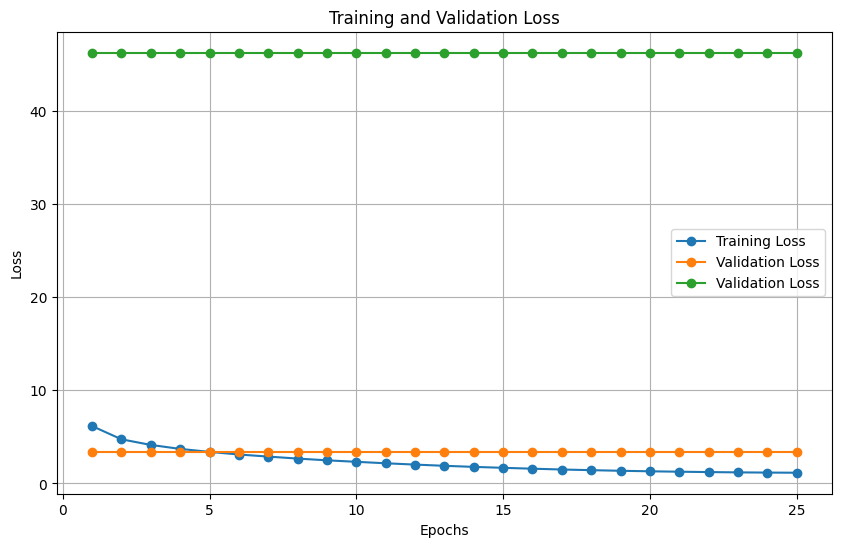

In [15]:
import torch
# from src.models.gpt2_model import GPT2Model
# from src.create_dataset.data_loading_splitting import load_and_split_data
# from src.models.config import GPT_CONFIG_124M
# from tests.train import train_model, save_model
# from tests.evaluate import validate_model
# from tests.visualisation import plot_loss

def main(csv_file, model_save_path="gpt2_model.pth", device="cuda"):
    # Load config
    config = GPT_CONFIG_124M

    # Load data
    train_loader, val_loader = load_and_split_data(csv_file=csv_file, config=config)

    # Check if data is loading correctly
    print(f"Training batches: {len(train_loader)}")  # Check how many batches you have
    print(f"Validation batches: {len(val_loader)}")  # Check how many validation batches you have

    # Initialize model
    print(f"Initializing model...")
    model = GPT2Model().to(device)

    # Train the model
    print(f"Starting training on {device}...")
    # Unpack three values from train_model (train_loss_history, train_accuracy_history, and model)
    train_loss_history, train_accuracy_history, model = train_model(model, train_loader, config, device)

    # Initialize an empty list for validation loss history
    val_loss_history = []

    # Validate the model after each epoch
    for epoch in range(config["epochs"]):
        print(f"Epoch {epoch + 1}/{config['epochs']} - Validating...")
        val_loss = validate_model(model, val_loader, device)
        print(f"Validation loss after epoch {epoch + 1}: {val_loss}")
        val_loss_history.append(val_loss)

    # Save the trained model
    print(f"Saving the trained model to {model_save_path}...")
    save_model(model, model_save_path)

    # Visualize training and validation loss
    print(f"Plotting the loss...")
    plot_loss(train_loss_history, val_loss_history)

if __name__ == "__main__":
    csv_file = r"/content/drive/MyDrive/gpt2/data/raw/medquad_1000.csv"  # Replace with the path to your dataset
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Running on device: {device}")
    main(csv_file, device=device)


### In the plot top line green color is  validation accuracy not validation loss 

In [ ]:
import torch
import tiktoken
# from src.models.gpt2_model import GPT2Model
# from src.models.config import GPT_CONFIG_124M

def load_model(model_path, device):
    """
    Load the model's weights and return the model.
    """
    model = GPT2Model().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))  # Load only weights
    model.eval()  # Set the model to evaluation mode
    return model

def sample_next_token_nucleus(logits, p=0.9, temperature=1.0):
    """
    Sample the next token using nucleus (top-p) sampling with temperature scaling.
    """
    # Apply temperature scaling to logits
    logits = logits / temperature

    # Clip extreme logits to prevent numerical overflow
    logits = torch.clamp(logits, -10.0, 10.0)

    # Convert logits to probabilities using softmax
    probs = torch.softmax(logits, dim=-1)

    # Check for NaN or Inf in probabilities and replace them with zero
    if torch.any(torch.isnan(probs)) or torch.any(torch.isinf(probs)):
        print("Warning: NaN or Inf found in probs")
        print(f"Logits before softmax: {logits}")
        raise ValueError("NaN or Inf detected in the probability distribution.")

    # Sort probabilities in descending order and get cumulative probabilities
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

    # Select only the tokens with cumulative probability less than p
    sorted_indices_to_keep = cumulative_probs < p
    sorted_probs[~sorted_indices_to_keep] = 0  # Set others to zero

    # Add a small epsilon value to avoid division by zero during renormalization
    epsilon = 1e-8
    sorted_probs /= sorted_probs.sum() + epsilon  # Re-normalize to form a valid probability distribution

    # Check for any NaN or Inf values after re-normalization
    if torch.any(torch.isnan(sorted_probs)) or torch.any(torch.isinf(sorted_probs)):
        print("Warning: NaN or Inf found after renormalization")
        print(f"Sorted Probs: {sorted_probs}")
        raise ValueError("NaN or Inf detected after re-normalizing the probability distribution.")

    # Sample the next token from the filtered probabilities
    next_token = torch.multinomial(sorted_probs, 1)

    # Return the corresponding token index from sorted indices
    return sorted_indices.gather(-1, next_token)

def generate_response(model, prompt, tokenizer, max_length=50, device="cpu", temperature=0.7, top_k=20, p=0.9):
    input_tokens = tokenizer.encode(prompt, allowed_special={'<|endoftext|>'})
    input_tensor = torch.tensor(input_tokens).unsqueeze(0).to(device)  # Add batch dimension

    generated_tokens = input_tensor

    with torch.no_grad():
        for _ in range(max_length):
            # Get the model's output (logits)
            logits = model(generated_tokens)

            # Focus on the last token's logits
            logits = logits[:, -1, :]

            # Sample the next token using nucleus sampling (top-p)
            next_token = sample_next_token_nucleus(logits, p=p, temperature=temperature)

            # Append the new token to the context
            generated_tokens = torch.cat((generated_tokens, next_token), dim=1)

            # Optionally check for the end-of-text token
            end_of_text_token = tokenizer.encode("<|endoftext|>", allowed_special={'<|endoftext|>'})[0]
            if next_token.item() == end_of_text_token:
                break

    # Decode the generated tokens to text
    output_text = tokenizer.decode(generated_tokens.squeeze().cpu().tolist())

    return output_text

def chat(model, tokenizer, device="cpu"):
    """
    Chat interface for interacting with the trained model.
    """
    print("Chatbot ready. Type 'exit' to end the chat.")

    while True:
        user_input = input("You: ")

        if user_input.lower() == "exit":
            print("Goodbye!")
            break

        # Generate response using the trained model
        response = generate_response(model, user_input, tokenizer, device=device, temperature=0.7, top_k=50, p=0.9)
        print(f"Bot: {response}")

def main():
    """
    Main function to initialize and run the chatbot.
    """
    model_path = r"/content/drive/MyDrive/gpt2/gpt2_model/gpt2_model_final.pth"  # Path to the trained model

    # Automatically choose device based on availability
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Running on device: {device}")

    # Load the tokenizer and the trained model
    tokenizer = tiktoken.get_encoding("gpt2")
    model = load_model(model_path, device)

    # Start the chatbot
    chat(model, tokenizer, device=device)

if __name__ == "__main__":
    main()


Running on device: cuda
Chatbot ready. Type 'exit' to end the chat.
You: Kidney Disease in Children
Bot: Kidney Disease in Children
Answer at greater risk for risk becoming groups offer classes and heart disease with cirrhosis should include heart attacks will come in which is used as a higher-American men and saturated fat or having heart problems such meat. You can prevent severe heart problems
You: Kidney Disease in Children
Bot: Kidney Disease in Children with an estimate of these medical terms or the body, they arent drink or    External radiation is a light sed, or injected near a vein may receive an important from growing before being tested to make a microscope atypical hernia 
You: Kidney Disease in Children
Bot: Kidney Disease in Children with the body's body to a body and a microscope by the blood cells called biotherapy:
  Some researchers are able can help reduce these tests. This procedure involves drawing a light. The pediatric from another protein are actually help prev